# Focal Loss vs Binary Cross-Entropy: A Practical Guide for Imbalanced Classification

Binary cross-entropy (BCE) is the default loss function for binary classification—but it breaks down badly on imbalanced datasets. The reason is subtle but important: BCE weighs mistakes from both classes equally, even when one class is extremely rare.

Imagine two predictions: a minority-class sample with true label 1 predicted at 0.3, and a majority-class sample with true label 0 predicted at 0.7. Both produce the same BCE value: −log(0.3). But should these two errors be treated equally? In an imbalanced dataset, definitely not—the mistake on the minority sample is far more costly.

This is exactly where Focal Loss comes in. It reduces the contribution of easy, confident predictions and amplifies the impact of difficult, minority-class examples. As a result, the model focuses less on the overwhelmingly easy majority class and more on the patterns that actually matter.

In this tutorial, we demonstrate this effect by training two identical neural networks on a dataset with a 99:1 imbalance ratio—one using BCE and the other using Focal Loss—and comparing their behavior, decision regions, and confusion matrices.

## Installing the dependencies

In [ ]:
!pip install numpy pandas matplotlib scikit-learn torch

## Create an Imbalanced Dataset
We create a synthetic binary classification dataset with a 99:1 imbalance with 6000 samples using make_classification. This ensures that almost all samples belong to the majority class, making it an ideal setup to demonstrate why BCE struggles and how Focal Loss helps.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

# Generate imbalanced dataset
X, y = make_classification(
    n_samples=6000,
    n_features=2,
    n_redundant=0,
    n_clusters_per_class=1,
    weights=[0.99, 0.01],
    class_sep=1.5,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
y_test  = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1)

## Creating the Neural Network
We define a simple neural network with two hidden layers to keep the experiment lightweight and focused on the loss functions. This small architecture is sufficient to learn the decision boundary in our 2D dataset while clearly highlighting the differences between BCE and Focal Loss.

In [33]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)


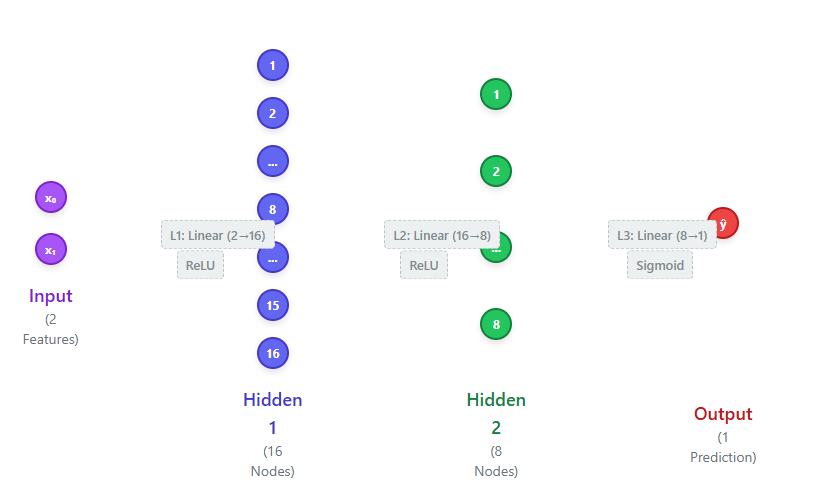

## Focal Loss Implementation
This class implements the Focal Loss function, which modifies binary cross-entropy by down-weighting easy examples and focusing the training on hard, misclassified samples. The gamma term controls how aggressively easy samples are suppressed, while alpha assigns higher weight to the minority class. Together, they help the model learn better on imbalanced datasets.

$$
FL = -\alpha (1 - p_t)^{\gamma} \log(p_t)
$$


In [34]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, targets):
        eps = 1e-7
        preds = torch.clamp(preds, eps, 1 - eps)

        pt = torch.where(targets == 1, preds, 1 - preds)
        loss = -self.alpha * (1 - pt) ** self.gamma * torch.log(pt)
        return loss.mean()


## Training the Model
We define a simple training loop that optimizes the model using the chosen loss function and evaluates accuracy on the test set. We then train two identical neural networks — one with standard BCE loss and the other with Focal Loss — allowing us to directly compare how each loss function performs on the same imbalanced dataset. The printed accuracies highlight the performance gap between BCE and Focal Loss.

Although BCE shows a very high accuracy (98%), this is misleading because the dataset is heavily imbalanced — predicting almost everything as the majority class still yields high accuracy. Focal Loss, on the other hand, improves minority-class detection, which is why its slightly higher accuracy (99%) is far more meaningful in this context.

In [45]:
def train(model, loss_fn, lr=0.01, epochs=30):
    opt = optim.Adam(model.parameters(), lr=lr)

    for _ in range(epochs):
        preds = model(X_train)
        loss = loss_fn(preds, y_train)
        opt.zero_grad()
        loss.backward()
        opt.step()

    with torch.no_grad():
        test_preds = model(X_test)
        test_acc = ((test_preds > 0.5).float() == y_test).float().mean().item()
    return test_acc, test_preds.squeeze().detach().numpy()

# Models
model_bce = SimpleNN()
model_focal = SimpleNN()

acc_bce, preds_bce = train(model_bce, nn.BCELoss())
acc_focal, preds_focal = train(model_focal, FocalLoss(alpha=0.25, gamma=2))

print("Test Accuracy (BCE):", acc_bce)
print("Test Accuracy (Focal Loss):", acc_focal)


Test Accuracy (BCE): 0.9850000143051147
Test Accuracy (Focal Loss): 0.9900000095367432


## Plotting the Decision Boundary
The BCE model produces an almost flat decision boundary that predicts only the majority class, completely ignoring the minority samples. This happens because, in an imbalanced dataset, BCE is dominated by the majority-class examples and learns to classify nearly everything as that class. In contrast, the Focal Loss model shows a much more refined and meaningful decision boundary, successfully identifying more minority-class regions and capturing patterns BCE fails to learn.

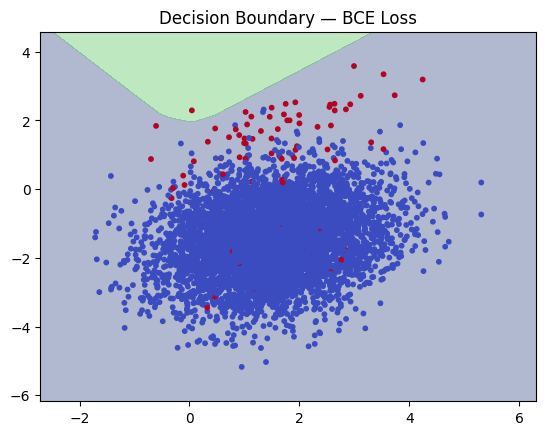

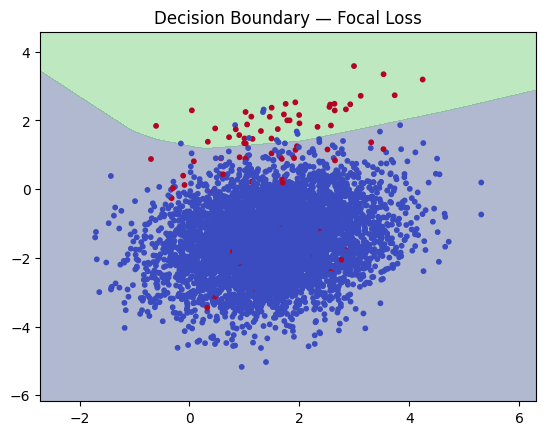

In [46]:
def plot_decision_boundary(model, title):
    # Create a grid
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        Z = model(grid).reshape(xx.shape)

    # Plot
    plt.contourf(xx, yy, Z, levels=[0,0.5,1], alpha=0.4)
    plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm', s=10)
    plt.title(title)
    plt.show()

plot_decision_boundary(model_bce, "Decision Boundary — BCE Loss")
plot_decision_boundary(model_focal, "Decision Boundary — Focal Loss")


## Plotting the Confusion Matrix
In the BCE model’s confusion matrix, the network correctly identifies only 1 minority-class sample, while misclassifying 27 of them as majority class. This shows that BCE collapses toward predicting almost everything as the majority class due to the imbalance. In contrast, the Focal Loss model correctly predicts 14 minority samples and reduces misclassifications from 27 down to 14. This demonstrates how Focal Loss places more emphasis on hard, minority-class examples, enabling the model to learn a decision boundary that actually captures the rare class instead of ignoring it.

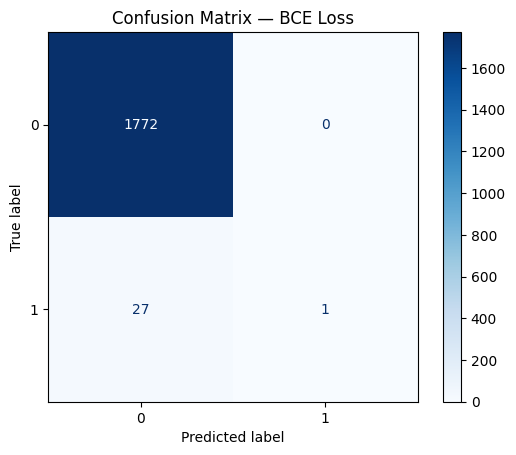

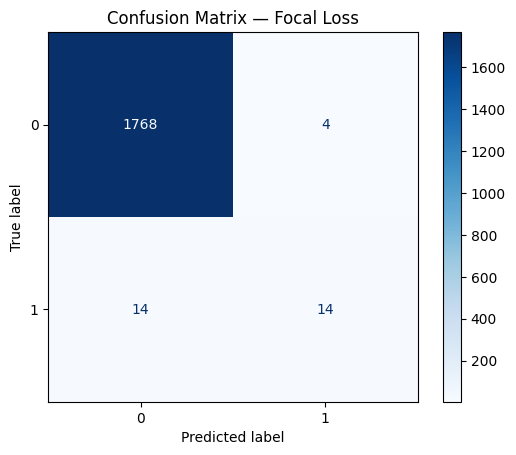

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format='d')
    plt.title(title)
    plt.show()

# Convert torch tensors to numpy
y_test_np = y_test.numpy().astype(int)

preds_bce_label   = (preds_bce > 0.5).astype(int)
preds_focal_label = (preds_focal > 0.5).astype(int)

plot_conf_matrix(y_test_np, preds_bce_label, "Confusion Matrix — BCE Loss")
plot_conf_matrix(y_test_np, preds_focal_label, "Confusion Matrix — Focal Loss")
